<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#smoothing-example" data-toc-modified-id="smoothing-example-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>smoothing example</a></span></li></ul></div>

# smoothing example

In [1]:
import numpy as np
import pandas as pd
import datetime 
import matplotlib.pyplot as plt 
from smoothing import piecewise_STL
from pathlib import Path

In [2]:
def repair_increasing(allcases):
    """
    fix for the negative value occurring in the daily: x_{t-7} *(X_{t-1}-X_{t-8})/(X_{t-8}-X_{t-15})
    then scaling to get the last cumulative value after negative value appears 
    """
    ind = np.diff(allcases)
    loc_negative = np.where(ind<0)[0]  
    for j in range(len(loc_negative)):
        i_neg = loc_negative[j] + 1 
        if i_neg < 15:
            for i in range(i_neg-1, 0, -1):
                if allcases[i+1] < allcases[i]:
                    allcases[i] = allcases[i+1]
        else: 
            cumul_toscale = allcases[i_neg].copy()
            coeff = (allcases[i_neg-1] - allcases[i_neg-8])/((allcases[i_neg-8] - allcases[i_neg-15])+1)
            daily = (allcases[i_neg-7] - allcases[i_neg-8]) *coeff
            allcases[i_neg] =  allcases[i_neg-1] + daily
            allcases[:i_neg+1] = allcases[:i_neg+1] * cumul_toscale / allcases[i_neg] 
    return allcases 

def read_countries_jhu(df, countries, number_startcases=0):
    """
    read the one dimensional cumulative casts data and the date starting from the day,
    when the number of cases is higher than number-startcases
    """
    allcases_list, date_list = [], []
    for country in countries:
        allcases_ = df[(df["Country/Region"] == country)].drop(["Province/State"],
                                                               axis=1).groupby(["Country/Region"]).sum().to_numpy()
        allcases_ = np.array(allcases_)[0, 4:]
        if np.max(allcases_) >= number_startcases:
            starting_point = np.min(np.where(allcases_ >= number_startcases)[0])
            allcases = allcases_[starting_point:]
         #   allcases = repair_increasing(allcases)
            date_ = pd.to_datetime(df.columns[5:])
            date_ = date_[starting_point:]
        else:
            print(country + " has a number of cases  less than the threshold ", number_startcases)
            allcases = []
            date_ = []
        allcases_list.append(allcases)
        date_list.append(date_)
    return allcases_list, date_list

In [53]:
path_data = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/745bab580799f0d0f304c87b974d2181cff489a0/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
datasource, parse_column = "JHU", "Country/Region"
df = pd.read_csv(path_data)
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/30/21,7/1/21,7/2/21,7/3/21,7/4/21,7/5/21,7/6/21,7/7/21,7/8/21,7/9/21
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,118659,120216,120216,120216,120216,125937,127464,129021,130113,131586
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,132521,132523,132526,132534,132535,132537,132544,132557,132565,132580
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,139626,140075,140550,141007,141471,141966,142447,143032,143652,144483
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,13911,13918,13918,13918,13918,13918,13991,14021,14050,14075
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,38849,38965,39089,39172,39230,39300,39375,39491,39593,39791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,NaN,Vietnam,14.058324,108.277199,0,2,2,2,2,2,...,17052,17727,18121,19310,20261,21312,22341,23385,24810,26608
275,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,314167,314288,314409,314492,314569,314569,314780,314869,314869,315047
276,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,6920,6923,6924,6926,6929,6929,6931,6934,6936,6940
277,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,154948,157832,160613,162487,164282,165513,167132,169003,170456,172405


In [54]:
countries = ["Germany"]  
cumulative_list, date_list = read_countries_jhu(df, countries)
cumulative = repair_increasing(cumulative_list[0]) 
daily = np.diff(cumulative)

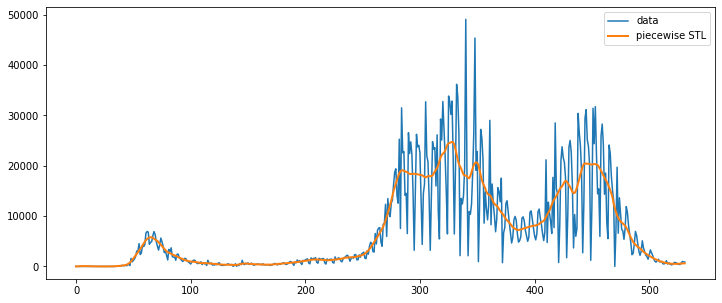

In [55]:
fig, ax = plt.subplots(1,1,figsize = (12,5))
ax.plot(daily)
smoothed = piecewise_STL(cumulative, 0, H=7)
ax.plot(np.diff(smoothed),lw=2)
plt.legend(["data","piecewise STL"]) 

In [56]:
SDSC_incid_2021_07_10 = pd.DataFrame({"date":date_list[0][2:], "I":np.diff(smoothed).round()})
SDSC_incid_2021_07_10.to_csv(Path("../incidence_data") / "SDSC_JHU_incid_21_07_10.csv", index=False)

In [24]:
path_data_rki = Path("../incidence_data")
datasource = "RKI"
df_rki = pd.read_csv(path_data_rki / "rtlive_incid_21_07_10.csv")

In [25]:
date_list_rki = [pd.DatetimeIndex(df_rki.iloc[:, 0])]
daily_rki = np.array(df_rki.iloc[:,1])
cumulative_rki = np.cumsum(daily_rki)

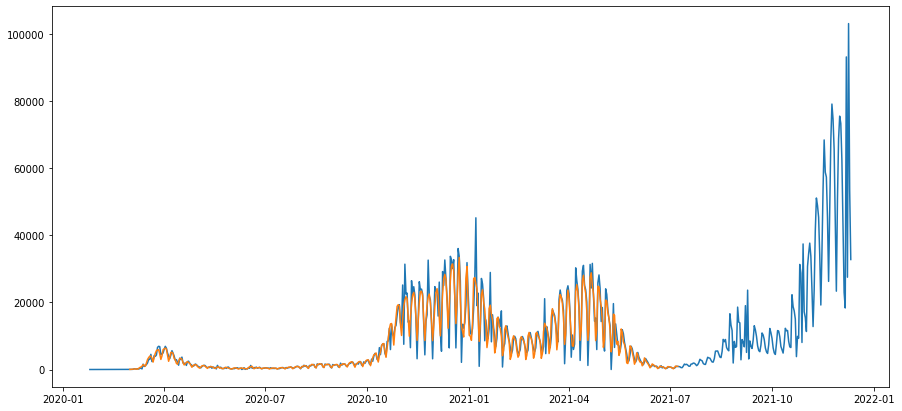

In [26]:
plt.figure(figsize=(15,7))
plt.plot(date_list[0][2:], daily)
plt.plot(date_list_rki[0], daily_rki)
plt.show()

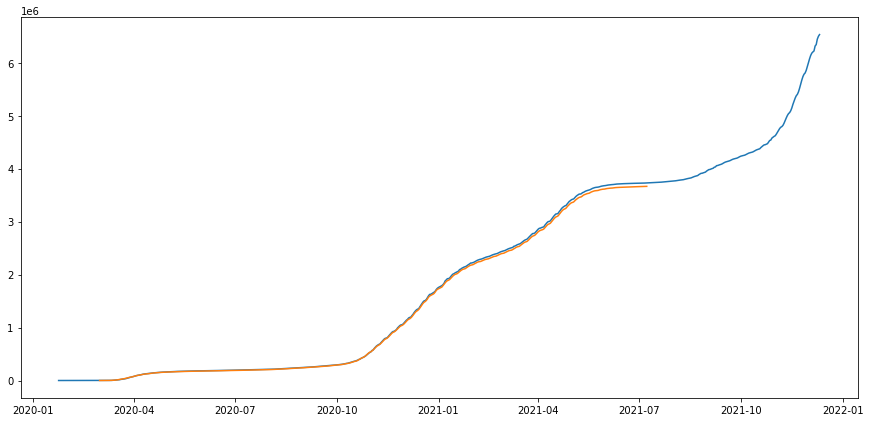

In [19]:
plt.figure(figsize=(15,7))
plt.plot(date_list[0][1:], cumulative)
plt.plot(date_list_rki[0], cumulative_rki)
plt.show()

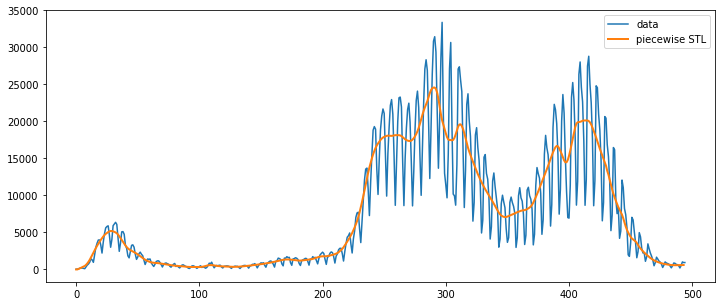

In [27]:
fig, ax = plt.subplots(1,1,figsize = (12,5))
ax.plot(daily_rki)
smoothed_rki = piecewise_STL(cumulative_rki, 0, H=7)
ax.plot(np.diff(smoothed_rki).round(),lw=2)
plt.legend(["data","piecewise STL"])

In [28]:
SDSC_incid = pd.DataFrame({"date":date_list_rki[0][1:], "I":np.diff(smoothed_rki).round()})
SDSC_incid

,date,I
0,2020-03-02,0.0
1,2020-03-03,0.0
2,2020-03-04,72.0
3,2020-03-05,148.0
4,2020-03-06,227.0
...,...,...
489,2021-07-04,581.0
490,2021-07-05,585.0
491,2021-07-06,589.0
492,2021-07-07,592.0


In [12]:
SDSC_incid.to_csv(path_data_rki / "SDSC_incid_21_07_10.csv", index=False)